In [32]:
import pandas as pd
import numpy as np

# Machine learnig management
import mlflow
from mlflow.models.signature import infer_signature

# vizualização de dados
import matplotlib.pyplot as plt
from yellowbrick.regressor import residuals_plot, prediction_error

# Bibliotecas para usar Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline

# Seleção e validação de modelos
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV

# Pré-processamento para incluir no pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler

# Modelos
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


#Manter saída do processamento do sklearn como DataFrame pandas
from sklearn import set_config
set_config(transform_output="pandas")



In [33]:
def get_metrics(y_true, y_pred):
  # Função que retorna as metricas de avaliação para esse modelo
  dict_metrics = {
      'R2': metrics.r2_score(y_true, y_pred),
      'MAE': metrics.mean_absolute_error(y_true, y_pred),
      'MAPE': metrics.mean_absolute_percentage_error(y_true, y_pred),
      'RMSE': np.sqrt(metrics.mean_squared_error(y_true, y_pred))
  }
  return dict_metrics

In [34]:
df = pd.read_csv('../data/insurance.csv')
df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


# Modeling

In [35]:
# Separando as nossas features
numerical_features = ['age', 'bmi', 'children']
categorical_features = ['smoker']

features = numerical_features + categorical_features
target = 'charges'

In [36]:
# Separando as bases de treino e teste
x = df[features]
y = df[target]

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=2024)

In [37]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = OneHotEncoder(drop='if_binary', sparse_output=False)

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['age', 'bmi', 'children']),
                                ('cat',
                                 OneHotEncoder(drop='if_binary',
                                               sparse_output=False),
                                 ['smoker'])])

In [38]:
preprocessor.fit_transform(x_train)

,num__age,num__bmi,num__children,cat__smoker_yes
899,0.021739,0.176352,0.0,0.0
1129,0.021739,0.071025,0.0,0.0
916,0.543478,0.293920,0.0,1.0
526,0.021739,0.393597,0.4,0.0
850,0.413043,0.398709,0.0,1.0
...,...,...,...,...
183,0.565217,0.281141,0.0,0.0
446,0.913043,0.368039,0.0,0.0
539,0.760870,0.414044,0.0,0.0
640,0.326087,0.711326,1.0,0.0


## Especificando os modelos que iremos fazer

In [39]:
models = {
        'Dummy':DummyRegressor(),
        'LinearRegression':LinearRegression(),
        'LassoCV':LassoCV(),
        'RidgeCV':RidgeCV(),
        'RandomForestRegressor':RandomForestRegressor(),
        'GradientBoostingRegressor':GradientBoostingRegressor()
}


In [40]:
# Criando um novo experimento
mlflow.set_experiment('Insurance')

<Experiment: artifact_location='file:///c:/Users/gusta/OneDrive/%C3%81rea%20de%20Trabalho/Cursos/DNC/Projetos/Estudo%20Ciencia%20de%20dados/Deploy/MLFLOW/notebooks/mlruns/209403677545209004', creation_time=1710845696618, experiment_id='209403677545209004', last_update_time=1710845696618, lifecycle_stage='active', name='Insurance', tags={}>

c:\Users\gusta\AppData\Local\Programs\Python\Python311\Lib\site-packages\mlflow\types\utils.py:393: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
c:\Users\gusta\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successf

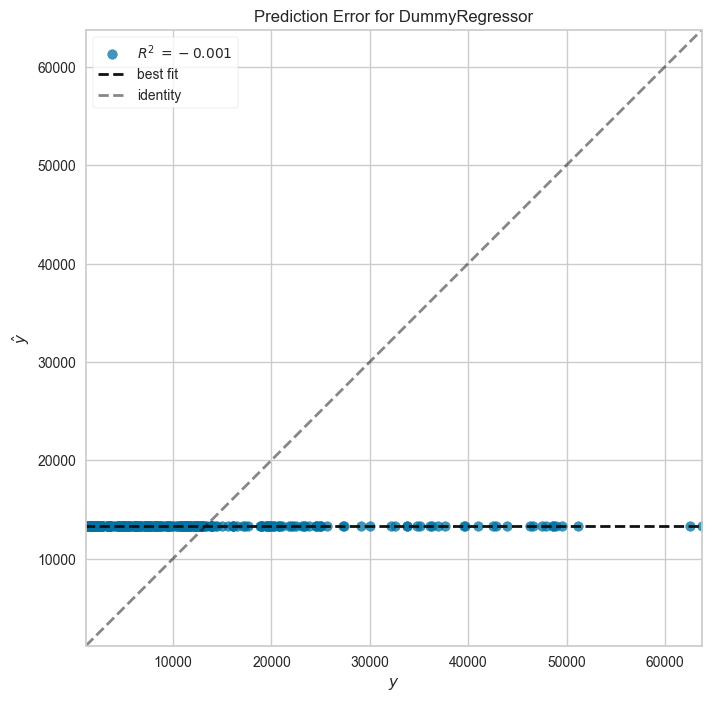

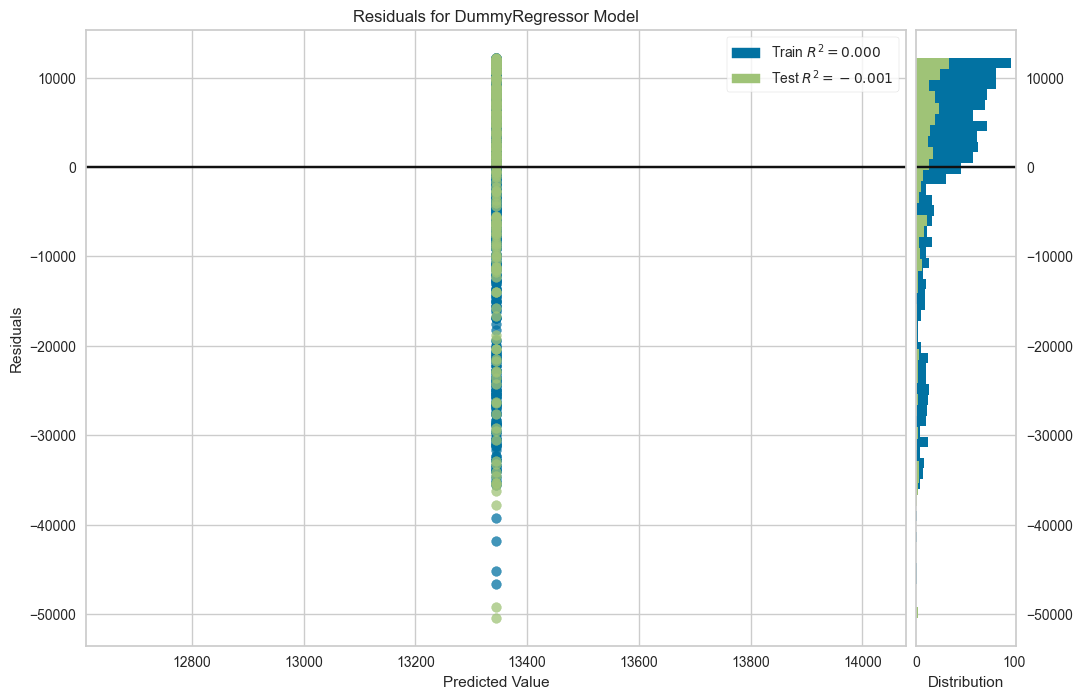

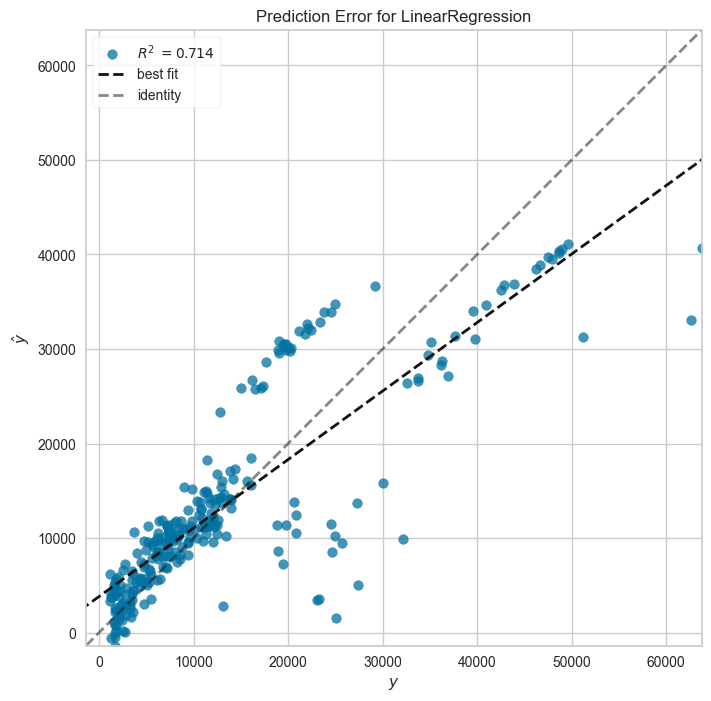

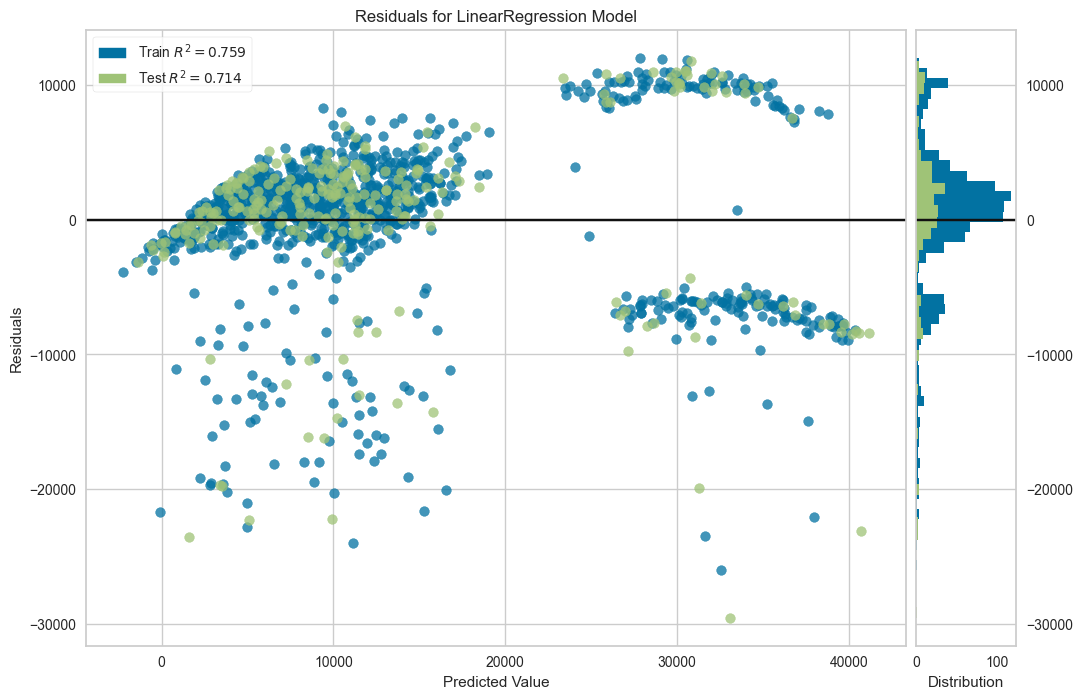

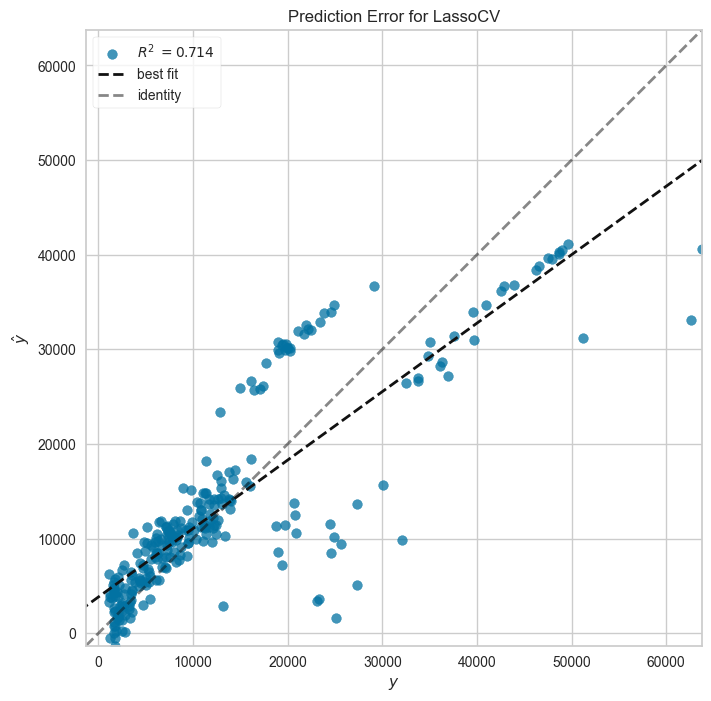

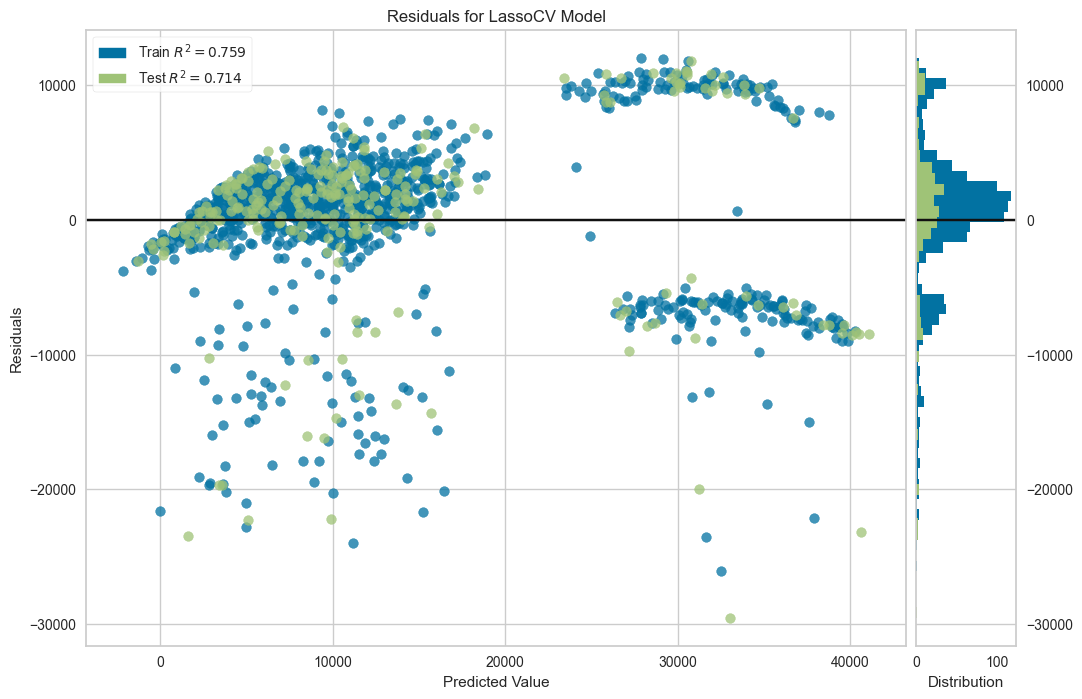

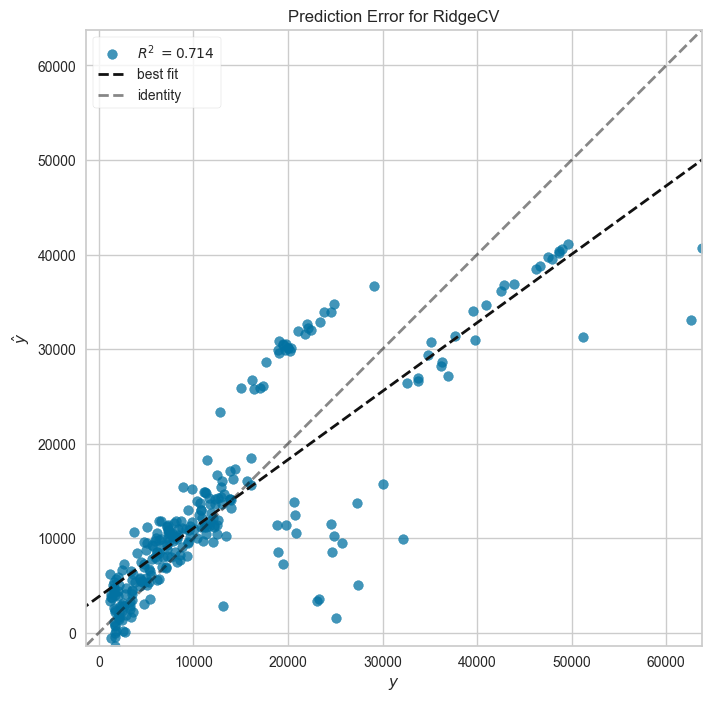

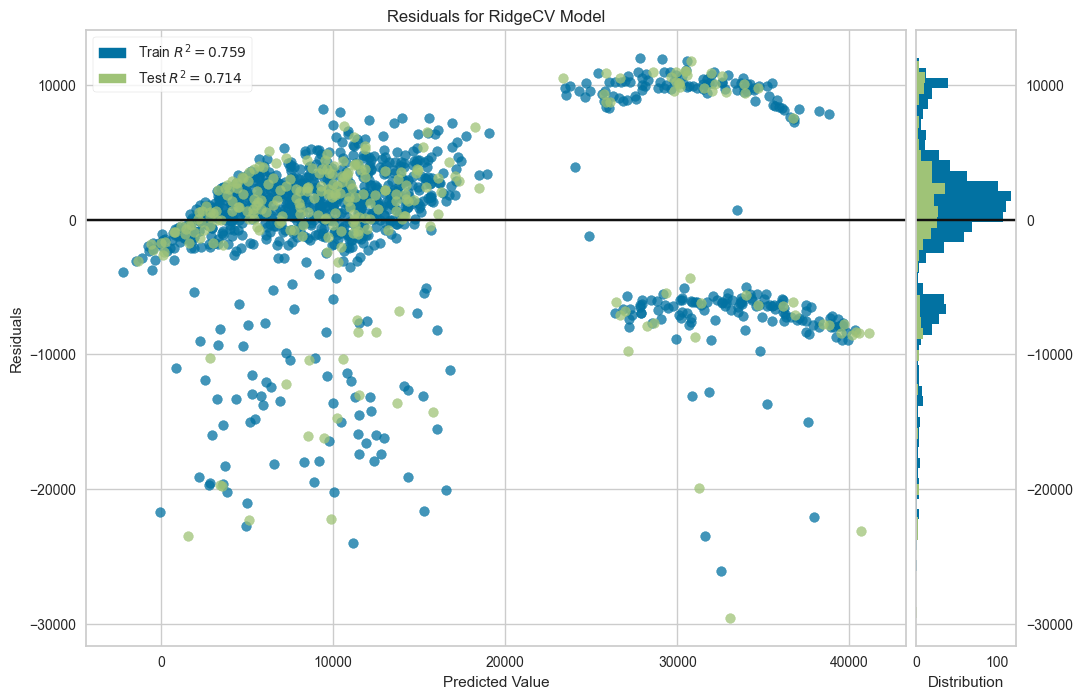

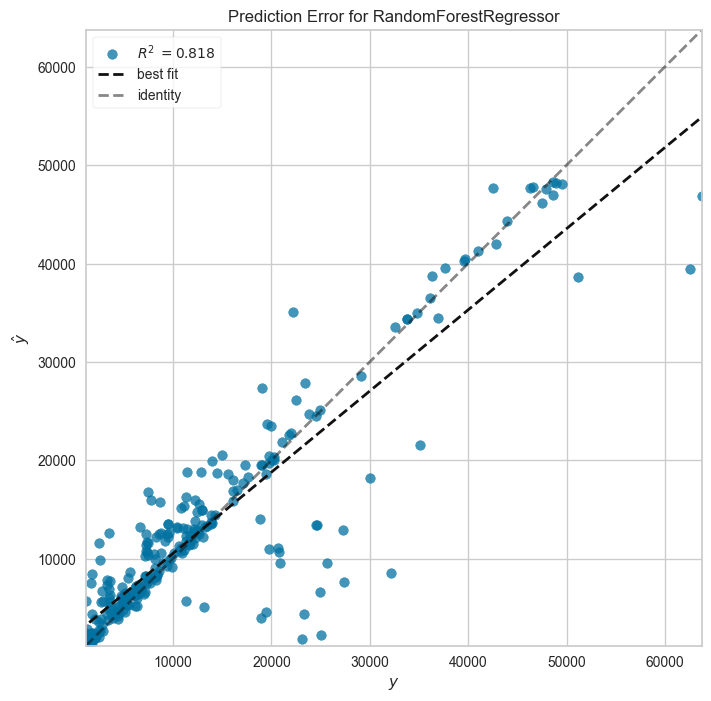

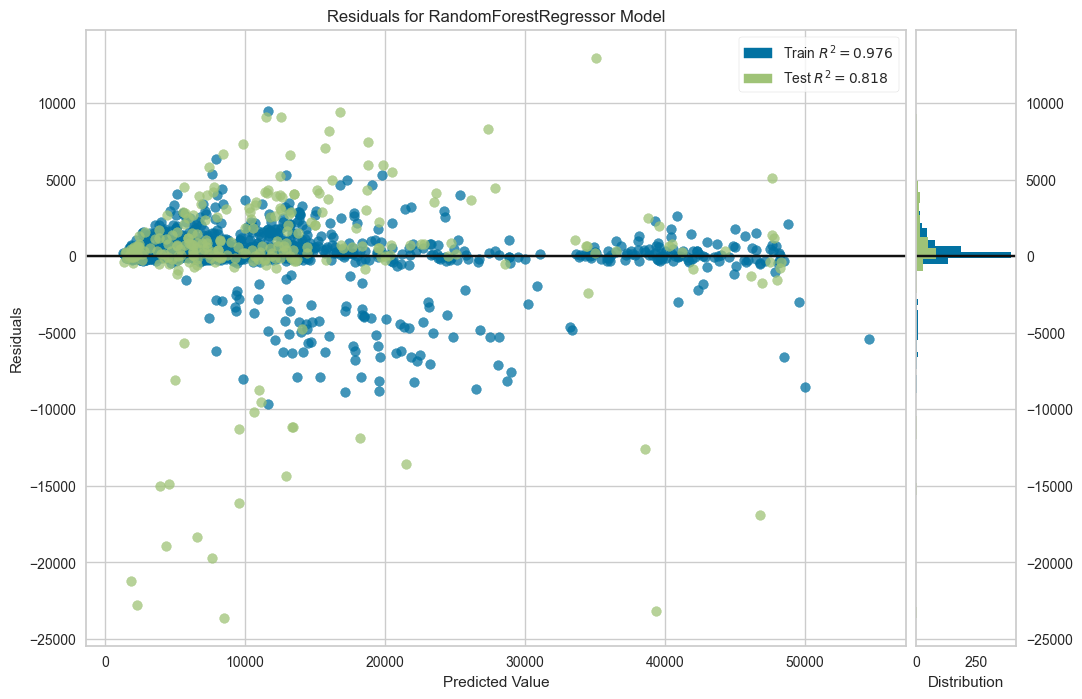

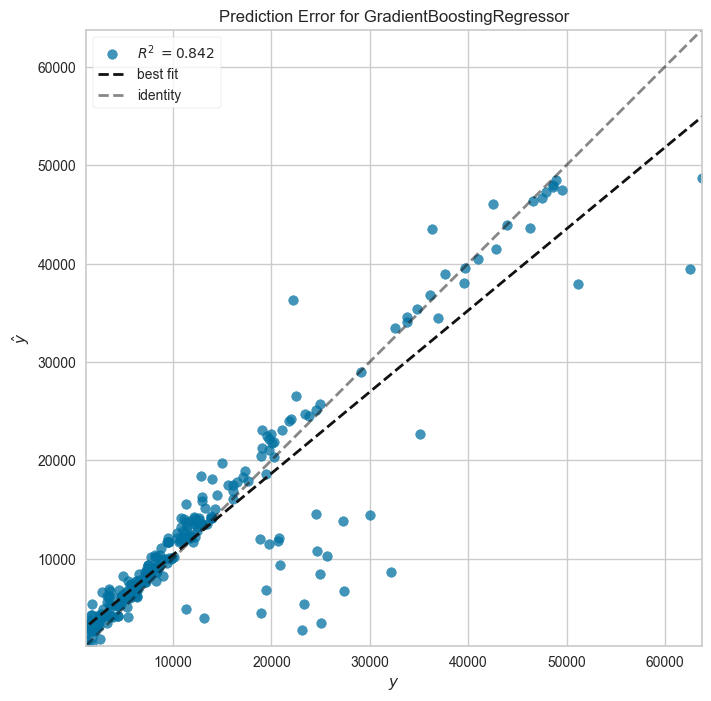

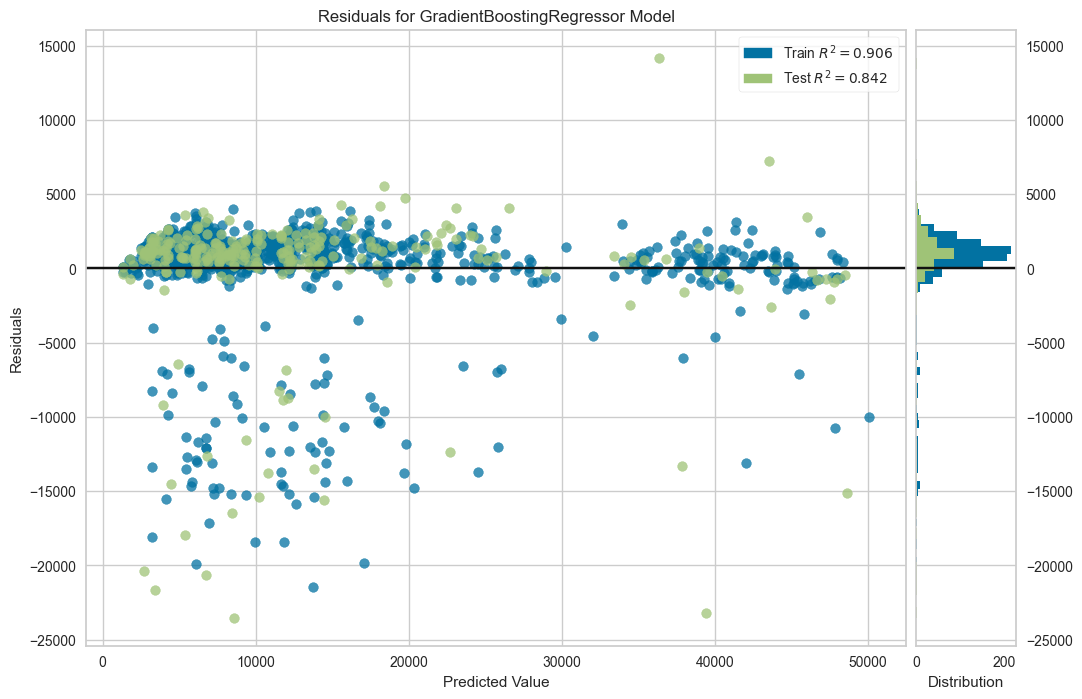

In [44]:
for model_name, model in models.items():
    #model Pipeline
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Treinar o modelo
    model_pipeline.fit(x_train, y_train)

    # Recebendo as predições
    y_pred = model_pipeline.predict(x_test)
    model_metrics =  get_metrics(y_test, y_pred)

    # Recebendo os parametros
    model_params = model_pipeline.named_steps['model'].get_params()


    # MLFlow
    with mlflow.start_run():
        #log metricas do modelo
        for metric_name, metric_value in model_metrics.items():
            mlflow.log_metric(metric_name, metric_value)
        # log hiperparametros
        mlflow.log_params(model_params)
        
        # Log das figuras
        fig, ax =  plt.subplots(figsize=(12,8))
        prediction_error(model_pipeline, x_train, y_train,x_test, y_test, show=False, ax=ax)
        mlflow.log_figure(fig, artifact_file='plots/prediction_error.png')
        

        fig, ax =  plt.subplots(figsize=(12,8))
        residuals_plot(model_pipeline, x_train, y_train,x_test, y_test, show=False, ax=ax)
        mlflow.log_figure(fig, artifact_file='plots/residuals_plot.png')
        
        # log do modelo
        signature = infer_signature(x_test, model_pipeline.predict(x_test))
        mlflow.sklearn.log_model(model_pipeline, 'model_pipeline', registered_model_name=model_name, signature=signature)
        
        
        
    
    

Signature:
mlflow.log_metric(
    key: str,
    value: float,
    step: Optional[int] = None,
    synchronous: Optional[bool] = None,
    timestamp: Optional[int] = None,
    run_id: Optional[str] = None,
) -> Optional[mlflow.utils.async_logging.run_operations.RunOperations]
Docstring:
Log a metric under the current run. If no run is active, this method will create
a new active run.

Args:
    key: Metric name. This string may only contain alphanumerics, underscores (_),
        dashes (-), periods (.), spaces ( ), and slashes (/).
        All backend stores will support keys up to length 250, but some may
        support larger keys.
    value: Metric value. Note that some special values such as +/- Infinity may be
        replaced by other values depending on the store. For example, the
        SQLAlchemy store replaces +/- Infinity with max / min float values.
        All backend stores will support values up to length 5000, but some
        may support larger values.
    step: Metr

## Tunagem modelo